# **Email spam Detection**


### **Libraries**

In [59]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
import string
import nltk
import warnings
from imblearn.over_sampling import SMOTE
from collections import Counter


# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Download stopwords if not already present
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### **1. Data Loading**
Load the dataset and show its info and statistics

In [31]:
# Load the dataset
dataset = pd.read_csv('dataset/emails.csv')
dataset.shape


(5728, 2)

In [32]:
# Show dataset head (first 5 records)
dataset.head() 

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [33]:
# Show dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [34]:
# Show dataset statistics
dataset.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


##### **2. Data Visualization**
Visualize dataset features frequencies to get some insights

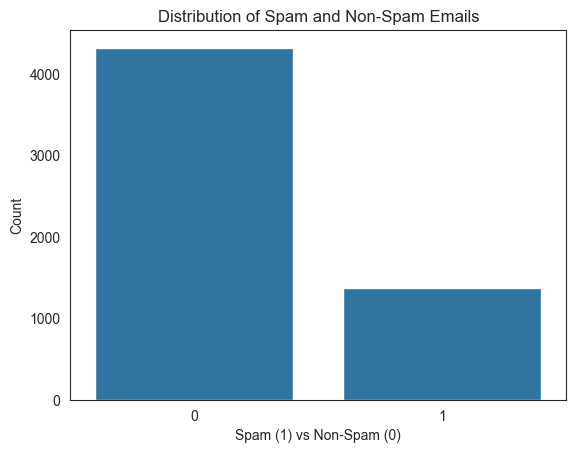

In [55]:
# Visualizing spam and non-spam counts
plt.figure(dpi=100)
sns.countplot(x='spam', data=dataset)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.xlabel('Spam (1) vs Non-Spam (0)')
plt.ylabel('Count')
plt.show()


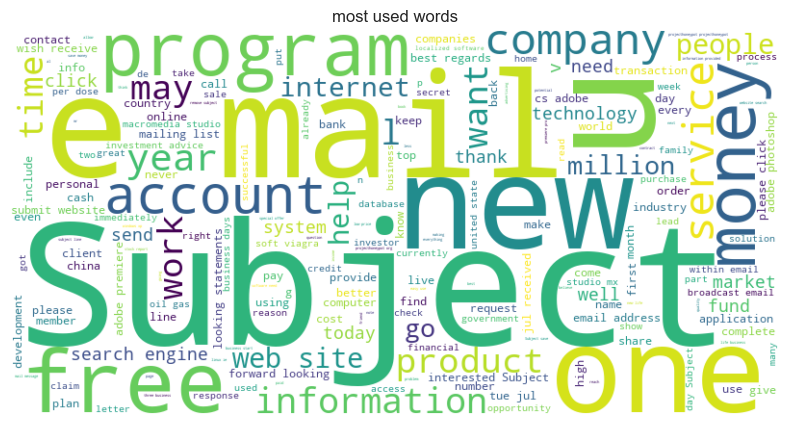

In [60]:
from wordcloud import WordCloud

# Separate spam and non-spam emails
spam_emails = dataset[dataset['spam'] == 1]['processed_text']
non_spam_emails = dataset[dataset['spam'] == 0]['processed_text']

# Generate word clouds
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails))
non_spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_spam_emails))

# Plot spam word cloud
plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('most used words')
plt.axis('off')
plt.show()



##### **3. Data Cleaning**
Handling missing values and check for duplicates 

In [36]:
# Check for missing data for each column 
dataset.isnull().sum()



text    0
spam    0
dtype: int64

In [37]:
# Check for duplicates and remove them 
dataset.drop_duplicates(inplace=True)


In [61]:
# Vectorize the text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dataset['processed_text'])

# Define the target (spam column)
y = dataset['spam']

# Check class distribution before applying SMOTE
print(f"Class distribution before SMOTE: {Counter(y)}")

# Apply SMOTE to oversample the minority class (spam)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Check class distribution after applying SMOTE
print(f"Class distribution after SMOTE: {Counter(y_smote)}")



Class distribution before SMOTE: Counter({0: 4327, 1: 1368})
Class distribution after SMOTE: Counter({1: 4327, 0: 4327})


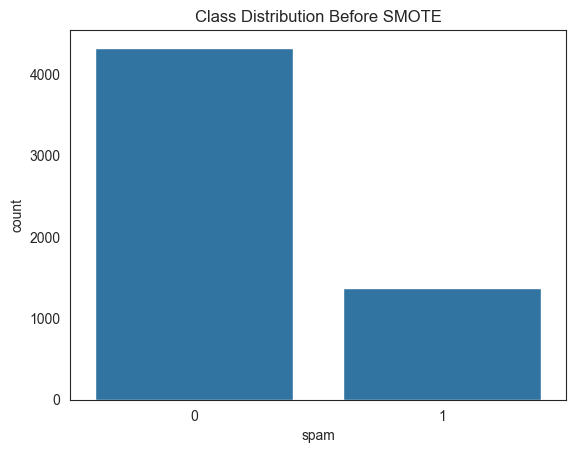

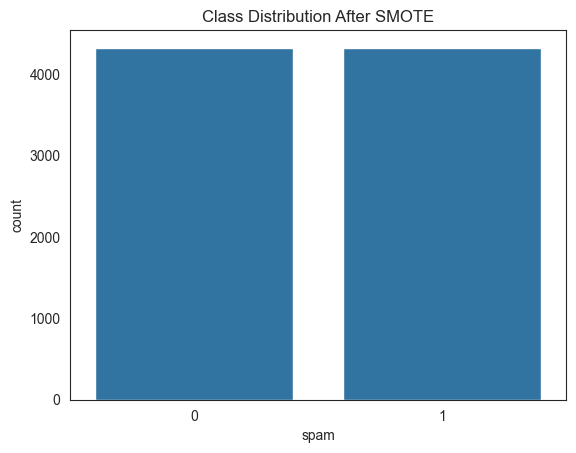

In [62]:
# Before SMOTE
plt.figure(dpi=100)
sns.countplot(x='spam', data=dataset)
plt.title('Class Distribution Before SMOTE')
plt.show()

# After SMOTE
plt.figure(dpi=100)
sns.countplot(x=y_smote)
plt.title('Class Distribution After SMOTE')
plt.show()


In [38]:

# Preprocessing function (remove punctuation and stopwords)
def process(text):
    nopunc = ''.join([char for char in text if char not in string.punctuation])
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])


In [39]:
# Apply preprocessing to the dataset
dataset['processed_text'] = dataset['text'].apply(process)


In [40]:
# Vectorize the text without custom preprocessor (process function applied outside the vectorizer)
vectorizer = CountVectorizer()
message = vectorizer.fit_transform(dataset['processed_text'])


##### **4. Data Splitting**
Split the dataset into training and testing sets

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(message, dataset['spam'], test_size=0.20, random_state=0)


## **3. The Model**
In this phase we will create and train a multinomial naive bayes model 

In [42]:
# Model creation
model = MultinomialNB()

In [43]:
# Model training
model.fit(X_train, y_train)

MultinomialNB()

In [15]:
# Model saving
# dump(model, open("models/model.pkl", 'wb'))

In [44]:
# Model predictions on test set
y_pred = model.predict(X_test)


In [45]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 99.12%


In [46]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       870
           1       0.97      0.99      0.98       269

    accuracy                           0.99      1139
   macro avg       0.98      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139



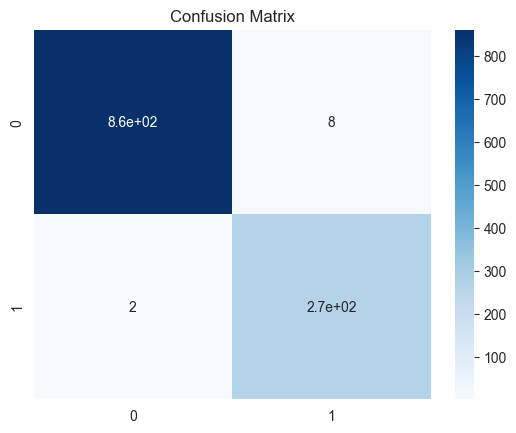

In [50]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(dpi=100)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [51]:
# Save the vectorizer and model (after training and testing)
pickle.dump(vectorizer, open("models/vectorizer.pkl", "wb"))
pickle.dump(model, open("models/model.pkl", "wb"))


In [53]:
# Function to predict whether a new email is spam or not
def predict_email(new_email):
    # Load the saved vectorizer and model
    vectorizer = pickle.load(open("models/vectorizer.pkl", "rb"))
    model = pickle.load(open("models/model.pkl", "rb"))
    
    # Preprocess the new email (same as dataset preprocessing)
    new_email_processed = process(new_email)
    
    # Transform the preprocessed email using the vectorizer
    new_email_vectorized = vectorizer.transform([new_email_processed])
    
    # Predict
    prediction = model.predict(new_email_vectorized)
    
    # Output the result
    if prediction == 1:
        print("The email is spam.")
    else:
        print("The email is not spam.")

# Test with a new email
new_email = """Dear Customer, you won lottery for 1000$ , claim it by sharing your bank details..."""
predict_email(new_email)


The email is spam.


In [54]:
import joblib

# Assuming model and vectorizer are already trained
joblib.dump(model, "models/model.pkl")
joblib.dump(vectorizer, "models/vectorizer.pkl")



['models/vectorizer.pkl']